In [1]:
# For data generation
import sys
# !{sys.executable} -m pip install matplotlib --upgrade
import shutil
import os
import numpy as np
from glob import glob
import re
import pandas as pd
import pickle
#random
from time import perf_counter

# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score,root_mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

#Plotting
import seaborn as sns
sns.set_style()
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 200

import warnings
# warnings.filterwarnings("ignore", category=np.DeprecationWarning) 


from tqdm.auto import tqdm
# from tqdm.notebook import tqdm_notebook as tqdm

In [2]:
def gen_lc(trainsize):
    with open(os.path.join(os.path.expanduser('~'),'DDCASPT2/drop.txt'),'r') as d:
        dropfeat = [i.replace('\n','') for i in d.readlines()]
        
    radius_range_dirs = []
    for i in glob('cluster/*.*'):
        try:
            radstr = float(os.path.basename(i))
            # if radstr>=1.4:
            radius_range_dirs.append(os.path.basename(i))
        except:
            continue
    
    radius_range = sorted(radius_range_dirs)
    
    train_ind,test_ind=radius_range[0::2],radius_range[1::2]
    
    train_ind = list(map(float,train_ind))
    test_ind = list(map(float,test_ind))
    train_ind, test_ind = train_test_split(train_ind+test_ind,train_size=trainsize, test_size=0.1, random_state=42)
    
    print(len(train_ind),len(test_ind))
    
    
    train = []
    test = []
    
    
    
    recover_train = []
    recover_test = []
    
    traincnt = 0
    testcnt = 0
    
    
    for k in train_ind:
        rad = f"{k:.2f}"
        traindf = pd.read_csv(os.path.join('cluster',rad,f'{rad}.csv'),compression='zip',index_col=0)
        # traindf = traindf[traindf['Pair_Energies'].abs()>=1e-7]
        train.append(traindf)
        recover_train.append((rad,traincnt,len(traindf)))
        traincnt+=1
            
    for l in test_ind:
        rad = f"{l:.2f}"
        testdf = pd.read_csv(os.path.join('cluster',rad,f'{rad}.csv'),compression='zip',index_col=0)
        # testdf = testdf[testdf['Pair_Energies'].abs()>=1e-7]
        test.append(testdf)                    
        recover_test.append((rad,testcnt,len(testdf)))
        testcnt+=1
    
    rename = {'h$_{qq}^{0}$':'h$_{q}$',
    '$(F_{q})_{0}$':'$F_{q}$',
    '$(F_{q}^{\\text{SCF}})_{0}$':'$F_{q}^{\\text{SCF}}$',
    '$(\\eta_{q})_{0}$':'$\\eta_{q}$',
    '$(\\omega_{q})_{0}$':'$\\omega_{q}$',
    '$(\\eta_{s})_{0}$':'$\\eta_{s}$',
    'h$_{ss}^{0}$':'h$_{s}$',
    '$(F_{s}^{\\text{SCF}})_{0}$':'$F_{s}^{\\text{SCF}}$',
    '$(F_{s})_{0}$':'$F_{s}$',
    '$(\\omega_{s})_{0}$':'$\\omega_{s}$',
    '$(\\langle ss \\vert ss \\rangle)_{0}$':"$\\langle ss \\vert ss \\rangle$",
    '$(\\langle qq \\vert qq \\rangle)_{0}$':"$\langle qq \\vert qq \\rangle$",
    'h$_{pp}^{0}$': 'h$_{p}^{0}$',
    'h$_{pp}^{1}$': 'h$_{p}^{1}$',
    'h$_{pp}^{2}$': 'h$_{p}^{2}$',
    'h$_{pp}^{3}$': 'h$_{p}^{3}$',
    'h$_{rr}^{0}$': 'h$_{r}^{0}$',
    'h$_{rr}^{1}$': 'h$_{r}^{1}$',
    'h$_{rr}^{2}$': 'h$_{r}^{2}$',
    'h$_{rr}^{3}$': 'h$_{r}^{3}$'}
    
    train_df = pd.concat(train).drop(columns=dropfeat).rename(columns=rename)
    test_df = pd.concat(test).drop(columns=dropfeat).rename(columns=rename)
    
    X_train = train_df.drop(columns=['Pair_Energies']).values
    X_test = test_df.drop(columns=['Pair_Energies']).values
    
    y_train = train_df['Pair_Energies'].values
    y_test = test_df['Pair_Energies'].values
    
    scaler=MinMaxScaler()
    X_train=scaler.fit_transform(X_train)
    X_test=scaler.transform(X_test)
    
    
    kwargs = dict(pd.read_excel("iron_VDZP_params.xlsx").values)
    model=XGBRegressor(**kwargs)
    model.fit(X_train,y_train)
    y_pred_train=model.predict(X_train)
    y_pred_test=model.predict(X_test)
    print(f"R2: {r2_score(y_train,y_pred_train):.4f},{r2_score(y_test,y_pred_test):.4f}")
    print(f"RMSE (mEh): {root_mean_squared_error(y_train,y_pred_train)*1e3:.4f},{root_mean_squared_error(y_test,y_pred_test)*1e3:.4f}")
    
    testcntrcvr = 0
    recover_test_list = []
    recover_test_E2 = []
    for j,k,l in recover_test:
        init_test = testcntrcvr
        testcntrcvr+=l
        recover_test_list.append((j,y_test[init_test:testcntrcvr],y_pred_test[init_test:testcntrcvr]))
        recover_test_E2.append((j,np.sum(y_test[init_test:testcntrcvr]),np.sum(y_pred_test[init_test:testcntrcvr])))
    
    
    traincntrcvr = 0
    recover_train_list = []
    recover_train_E2 = []
    for j,k,l in recover_train:
        init_train = traincntrcvr
        traincntrcvr+=l
        recover_train_list.append((j,y_train[init_train:traincntrcvr],y_pred_train[init_train:traincntrcvr]))
        recover_train_E2.append((j,np.sum(y_train[init_train:traincntrcvr]),np.sum(y_pred_train[init_train:traincntrcvr])))
    
    traincorrE2 = pd.DataFrame(recover_train_E2).rename(columns={0:'Radius ($\AA$)',1:'E$_{2}^{\text{Calculated}}$',2:'E$_{2}^{\text{Predicted}}$'}).set_index('Radius ($\AA$)')
    #.astype({"basis set":str,'Radius ($\AA$)':float,'E$_{2}^{\text{Calculated}}$':float,'E$_{2}^{\text{Predicted}}$':float})
    testcorrE2 = pd.DataFrame(recover_test_E2).rename(columns={0:'Radius ($\AA$)',1:'E$_{2}^{\text{Calculated}}$',2:'E$_{2}^{\text{Predicted}}$'}).set_index('Radius ($\AA$)')
    #.astype({"basis set":str,'Radius ($\AA$)':float,'E$_{2}^{\text{Calculated}}$':float,'E$_{2}^{\text{Predicted}}$':float})
    
    
    
    traincorrE2['CASPT2_E']=np.zeros(len(traincorrE2))
    traincorrE2['CASSCF_E']=np.zeros(len(traincorrE2))
    traincorrE2['E2']=np.zeros(len(traincorrE2))
    
    
    
    for i in traincorrE2.index:
        energy_df = pd.read_excel(f"cluster/{i}/{i}_energies.xlsx",index_col=0)
        traincorrE2.loc[i,'CASPT2_E']=energy_df.loc['CASPT2_E'].values
        traincorrE2.loc[i,'CASSCF_E']=energy_df.loc['CASSCF_E'].values
        # traincorrE2.loc[i,'E2']=energy_df.loc['E2'].values
    
    traincorrE2['E$_{\text{CASPT2}}^{\text{Predicted}}$'] = traincorrE2['CASSCF_E']+traincorrE2['E$_{2}^{\text{Predicted}}$']
    
    traincorrE2.rename(columns = {'CASPT2_E':'E$_{\text{CASPT2}}^{\text{Calculated}}$','CASSCF_E':'E$_{\text{CASSCF}}^{\text{Calculated}}$'},inplace=True)
    
    
    testcorrE2['CASPT2_E']=np.zeros(len(testcorrE2))
    testcorrE2['CASSCF_E']=np.zeros(len(testcorrE2))
    testcorrE2['E2']=np.zeros(len(testcorrE2))
    
    
    
    for i in testcorrE2.index:
        energy_df = pd.read_excel(f"cluster/{i}/{i}_energies.xlsx",index_col=0)
        testcorrE2.loc[i,'CASPT2_E']=energy_df.loc['CASPT2_E'].values
        testcorrE2.loc[i,'CASSCF_E']=energy_df.loc['CASSCF_E'].values
        # testcorrE2.loc[i,'E2']=energy_df.loc['E2'].values
    
    testcorrE2['E$_{\text{CASPT2}}^{\text{Predicted}}$'] = testcorrE2['CASSCF_E']+testcorrE2['E$_{2}^{\text{Predicted}}$']
    
    testcorrE2.rename(columns = {'CASPT2_E':'E$_{\text{CASPT2}}^{\text{Calculated}}$','CASSCF_E':'E$_{\text{CASSCF}}^{\text{Calculated}}$'},inplace=True)
    
    testcorrE2.reset_index(inplace=True)
    traincorrE2.reset_index(inplace=True)    
    
    return ((y_train,y_pred_train), (y_test,y_pred_test), (traincorrE2, testcorrE2))

In [3]:
data = []
for i in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    data.append((int(i * 500),gen_lc(i)))

50 50
R2: 0.9940,0.9136
RMSE (mEh): 0.1620,0.6111
100 50
R2: 0.9956,0.9522
RMSE (mEh): 0.1375,0.4546
150 50
R2: 0.9965,0.9551
RMSE (mEh): 0.1231,0.4404
200 50
R2: 0.9970,0.9673
RMSE (mEh): 0.1141,0.3760
250 50
R2: 0.9974,0.9692
RMSE (mEh): 0.1061,0.3647
300 50
R2: 0.9976,0.9718
RMSE (mEh): 0.1025,0.3493
350 50
R2: 0.9977,0.9786
RMSE (mEh): 0.0988,0.3042
400 50
R2: 0.9979,0.9734
RMSE (mEh): 0.0953,0.3388
450 50
R2: 0.9980,0.9816
RMSE (mEh): 0.0928,0.2818


In [4]:
pair_r2 = []
pair_mae = []
corr_r2 = []
corr_mae = []
for (i,((y_train,y_pred_train), (y_test,y_pred_test), (traincorrE2, testcorrE2))) in data:
    traincorrE2_true = traincorrE2['E$_{2}^{\text{Calculated}}$']
    traincorrE2_pred = traincorrE2['E$_{2}^{\text{Predicted}}$']

    testcorrE2_true = testcorrE2['E$_{2}^{\text{Calculated}}$']
    testcorrE2_pred = testcorrE2['E$_{2}^{\text{Predicted}}$']
    
    pair_r2.append((i,r2_score(y_train,y_pred_train),r2_score(y_test,y_pred_test)))
    pair_mae.append((i,1e3 * mean_absolute_error(y_train,y_pred_train),1e3 * mean_absolute_error(y_test,y_pred_test)))

    corr_r2.append((i,r2_score(traincorrE2_true,traincorrE2_pred),r2_score(testcorrE2_true,testcorrE2_pred)))
    corr_mae.append((i,1e3 * mean_absolute_error(traincorrE2_true,traincorrE2_pred),1e3 * mean_absolute_error(testcorrE2_true,testcorrE2_pred)))

dfpair_r2 = pd.DataFrame(pair_r2,columns=['Train Size', "Train", "Test"])
dfcorr_r2 = pd.DataFrame(corr_r2,columns=['Train Size', "Train", "Test"])
dfpair_mae = pd.DataFrame(pair_mae,columns=['Train Size', "Train", "Test"])
dfcorr_mae = pd.DataFrame(corr_mae,columns=['Train Size', "Train", "Test"])

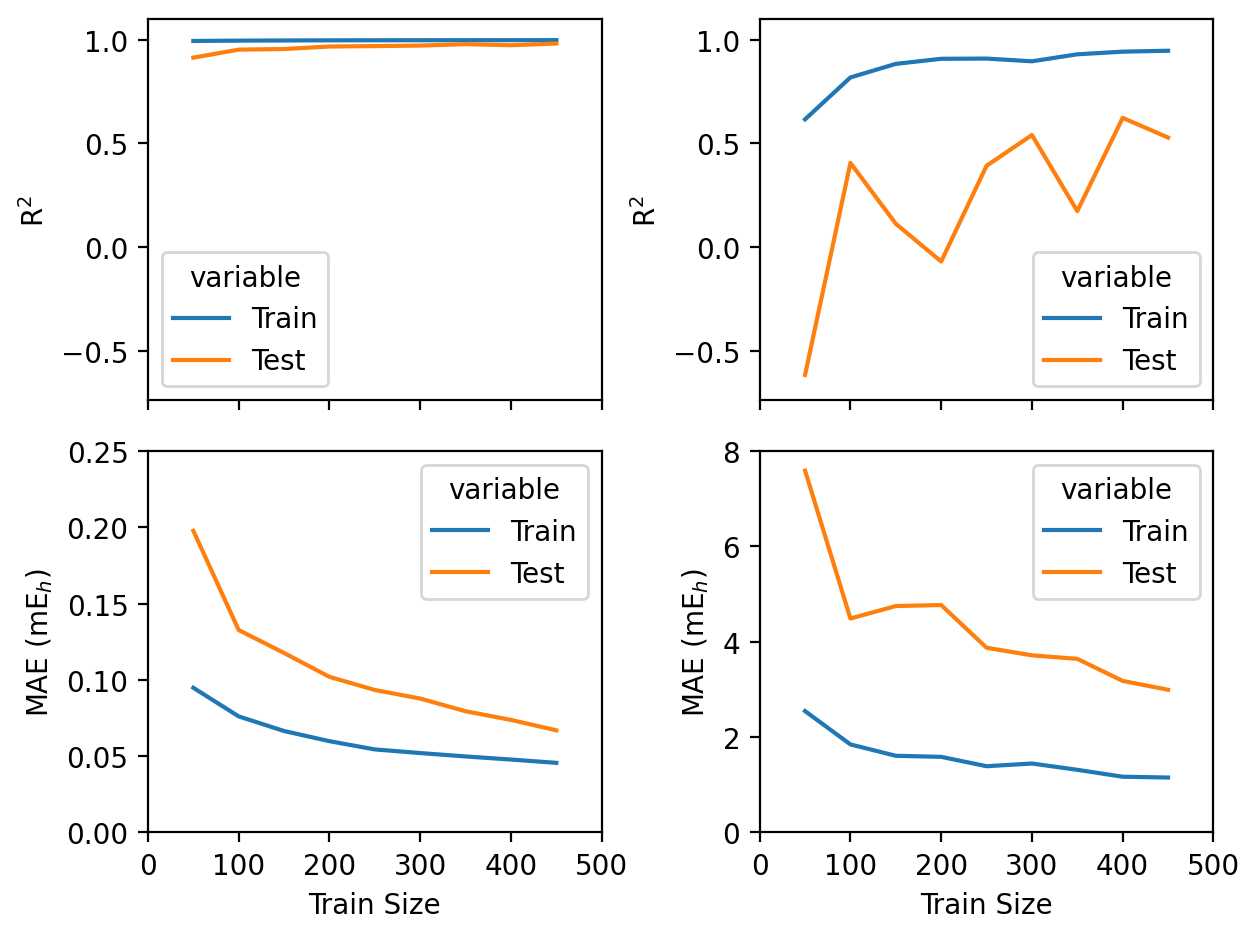

In [30]:
fig, ax = plt.subplots(2,2,sharex=True)
sns.lineplot(dfpair_r2.melt(id_vars='Train Size',value_vars=['Train','Test']),x='Train Size',y='value', hue='variable',ax=ax[0][0])
sns.lineplot(dfcorr_r2.melt(id_vars='Train Size',value_vars=['Train','Test']),x='Train Size',y='value', hue='variable',ax=ax[0][1],markers='x')
ax[0][0].set_xlim(0,500)
ax[0][1].set_xlim(0,500)
ax[0][0].set_ylim(-.74,1.1)
ax[0][1].set_ylim(-.74,1.1)
ax[0][0].set_ylabel("R$^{2}$")
ax[0][1].set_ylabel("R$^{2}$")
sns.lineplot(dfpair_mae.melt(id_vars='Train Size',value_vars=['Train','Test']),x='Train Size',y='value', hue='variable',ax=ax[1][0])
ax[1][0].set_ylim(0,0.25)
sns.lineplot(dfcorr_mae.melt(id_vars='Train Size',value_vars=['Train','Test']),x='Train Size',y='value', hue='variable',ax=ax[1][1])
ax[1][1].set_ylim(0,8)
ax[1][0].set_ylabel("MAE (mE$_{h}$)")
ax[1][1].set_ylabel("MAE (mE$_{h}$)")
plt.tight_layout()
plt.savefig('images/learning_curves.png',dpi=300,bbox_inches='tight')

In [41]:
def gen_cut(cutoff):
    with open(os.path.join(os.path.expanduser('~'),'DDCASPT2/drop.txt'),'r') as d:
        dropfeat = [i.replace('\n','') for i in d.readlines()]
        
    radius_range_dirs = []
    for i in glob('cluster/*.*'):
        try:
            radstr = float(os.path.basename(i))
            # if radstr>=1.4:
            radius_range_dirs.append(os.path.basename(i))
        except:
            continue
    
    radius_range = sorted(radius_range_dirs)
    
    train_ind,test_ind=radius_range[0::2],radius_range[1::2]
    
    train_ind = list(map(float,train_ind))
    test_ind = list(map(float,test_ind))
    train_ind, test_ind = train_test_split(train_ind+test_ind, test_size=0.1, random_state=42)
    
    print(len(train_ind),len(test_ind))
    
    
    train = []
    test = []
    
    
    
    recover_train = []
    recover_test = []
    
    traincnt = 0
    testcnt = 0
    
    
    for k in train_ind:
        rad = f"{k:.2f}"
        traindf = pd.read_csv(os.path.join('cluster',rad,f'{rad}.csv'),compression='zip',index_col=0)
        traindf = traindf[traindf['Pair_Energies'].abs()>=cutoff]
        train.append(traindf)
        recover_train.append((rad,traincnt,len(traindf)))
        traincnt+=1
            
    for l in test_ind:
        rad = f"{l:.2f}"
        testdf = pd.read_csv(os.path.join('cluster',rad,f'{rad}.csv'),compression='zip',index_col=0)
        testdf = testdf[testdf['Pair_Energies'].abs()>=cutoff]
        test.append(testdf)                    
        recover_test.append((rad,testcnt,len(testdf)))
        testcnt+=1
    
    rename = {'h$_{qq}^{0}$':'h$_{q}$',
    '$(F_{q})_{0}$':'$F_{q}$',
    '$(F_{q}^{\\text{SCF}})_{0}$':'$F_{q}^{\\text{SCF}}$',
    '$(\\eta_{q})_{0}$':'$\\eta_{q}$',
    '$(\\omega_{q})_{0}$':'$\\omega_{q}$',
    '$(\\eta_{s})_{0}$':'$\\eta_{s}$',
    'h$_{ss}^{0}$':'h$_{s}$',
    '$(F_{s}^{\\text{SCF}})_{0}$':'$F_{s}^{\\text{SCF}}$',
    '$(F_{s})_{0}$':'$F_{s}$',
    '$(\\omega_{s})_{0}$':'$\\omega_{s}$',
    '$(\\langle ss \\vert ss \\rangle)_{0}$':"$\\langle ss \\vert ss \\rangle$",
    '$(\\langle qq \\vert qq \\rangle)_{0}$':"$\langle qq \\vert qq \\rangle$",
    'h$_{pp}^{0}$': 'h$_{p}^{0}$',
    'h$_{pp}^{1}$': 'h$_{p}^{1}$',
    'h$_{pp}^{2}$': 'h$_{p}^{2}$',
    'h$_{pp}^{3}$': 'h$_{p}^{3}$',
    'h$_{rr}^{0}$': 'h$_{r}^{0}$',
    'h$_{rr}^{1}$': 'h$_{r}^{1}$',
    'h$_{rr}^{2}$': 'h$_{r}^{2}$',
    'h$_{rr}^{3}$': 'h$_{r}^{3}$'}
    
    train_df = pd.concat(train).drop(columns=dropfeat).rename(columns=rename)
    test_df = pd.concat(test).drop(columns=dropfeat).rename(columns=rename)
    
    X_train = train_df.drop(columns=['Pair_Energies']).values
    X_test = test_df.drop(columns=['Pair_Energies']).values
    
    y_train = train_df['Pair_Energies'].values
    y_test = test_df['Pair_Energies'].values
    
    scaler=MinMaxScaler()
    X_train=scaler.fit_transform(X_train)
    X_test=scaler.transform(X_test)
    
    
    kwargs = dict(pd.read_excel("iron_VDZP_params.xlsx").values)
    model=XGBRegressor(**kwargs)
    model.fit(X_train,y_train)
    y_pred_train=model.predict(X_train)
    y_pred_test=model.predict(X_test)
    print(f"R2: {r2_score(y_train,y_pred_train):.4f},{r2_score(y_test,y_pred_test):.4f}")
    print(f"RMSE (mEh): {root_mean_squared_error(y_train,y_pred_train)*1e3:.4f},{root_mean_squared_error(y_test,y_pred_test)*1e3:.4f}")
    
    testcntrcvr = 0
    recover_test_list = []
    recover_test_E2 = []
    for j,k,l in recover_test:
        init_test = testcntrcvr
        testcntrcvr+=l
        recover_test_list.append((j,y_test[init_test:testcntrcvr],y_pred_test[init_test:testcntrcvr]))
        recover_test_E2.append((j,np.sum(y_test[init_test:testcntrcvr]),np.sum(y_pred_test[init_test:testcntrcvr])))
    
    
    traincntrcvr = 0
    recover_train_list = []
    recover_train_E2 = []
    for j,k,l in recover_train:
        init_train = traincntrcvr
        traincntrcvr+=l
        recover_train_list.append((j,y_train[init_train:traincntrcvr],y_pred_train[init_train:traincntrcvr]))
        recover_train_E2.append((j,np.sum(y_train[init_train:traincntrcvr]),np.sum(y_pred_train[init_train:traincntrcvr])))
    
    traincorrE2 = pd.DataFrame(recover_train_E2).rename(columns={0:'Radius ($\AA$)',1:'E$_{2}^{\text{Calculated}}$',2:'E$_{2}^{\text{Predicted}}$'}).set_index('Radius ($\AA$)')
    #.astype({"basis set":str,'Radius ($\AA$)':float,'E$_{2}^{\text{Calculated}}$':float,'E$_{2}^{\text{Predicted}}$':float})
    testcorrE2 = pd.DataFrame(recover_test_E2).rename(columns={0:'Radius ($\AA$)',1:'E$_{2}^{\text{Calculated}}$',2:'E$_{2}^{\text{Predicted}}$'}).set_index('Radius ($\AA$)')
    #.astype({"basis set":str,'Radius ($\AA$)':float,'E$_{2}^{\text{Calculated}}$':float,'E$_{2}^{\text{Predicted}}$':float})
    
    
    
    traincorrE2['CASPT2_E']=np.zeros(len(traincorrE2))
    traincorrE2['CASSCF_E']=np.zeros(len(traincorrE2))
    traincorrE2['E2']=np.zeros(len(traincorrE2))
    
    
    
    for i in traincorrE2.index:
        energy_df = pd.read_excel(f"cluster/{i}/{i}_energies.xlsx",index_col=0)
        traincorrE2.loc[i,'CASPT2_E']=energy_df.loc['CASPT2_E'].values
        traincorrE2.loc[i,'CASSCF_E']=energy_df.loc['CASSCF_E'].values
        # traincorrE2.loc[i,'E2']=energy_df.loc['E2'].values
    
    traincorrE2['E$_{\text{CASPT2}}^{\text{Predicted}}$'] = traincorrE2['CASSCF_E']+traincorrE2['E$_{2}^{\text{Predicted}}$']
    
    traincorrE2.rename(columns = {'CASPT2_E':'E$_{\text{CASPT2}}^{\text{Calculated}}$','CASSCF_E':'E$_{\text{CASSCF}}^{\text{Calculated}}$'},inplace=True)
    
    
    testcorrE2['CASPT2_E']=np.zeros(len(testcorrE2))
    testcorrE2['CASSCF_E']=np.zeros(len(testcorrE2))
    testcorrE2['E2']=np.zeros(len(testcorrE2))
    
    
    
    for i in testcorrE2.index:
        energy_df = pd.read_excel(f"cluster/{i}/{i}_energies.xlsx",index_col=0)
        testcorrE2.loc[i,'CASPT2_E']=energy_df.loc['CASPT2_E'].values
        testcorrE2.loc[i,'CASSCF_E']=energy_df.loc['CASSCF_E'].values
        # testcorrE2.loc[i,'E2']=energy_df.loc['E2'].values
    
    testcorrE2['E$_{\text{CASPT2}}^{\text{Predicted}}$'] = testcorrE2['CASSCF_E']+testcorrE2['E$_{2}^{\text{Predicted}}$']
    
    testcorrE2.rename(columns = {'CASPT2_E':'E$_{\text{CASPT2}}^{\text{Calculated}}$','CASSCF_E':'E$_{\text{CASSCF}}^{\text{Calculated}}$'},inplace=True)
    
    testcorrE2.reset_index(inplace=True)
    traincorrE2.reset_index(inplace=True)    
    
    return ((y_train,y_pred_train), (y_test,y_pred_test), (traincorrE2, testcorrE2))

In [48]:
14-3

11

array([1.e-14, 1.e-13, 1.e-12, 1.e-11, 1.e-10, 1.e-09, 1.e-08, 1.e-07,
       1.e-06, 1.e-05, 1.e-04, 1.e-03])

In [54]:
data = []
for i in np.logspace(-14,-3,12):
    print(i)
    data.append((i,gen_cut(i)))


pair_r2 = []
pair_mae = []
corr_r2 = []
corr_mae = []
for (i,((y_train,y_pred_train), (y_test,y_pred_test), (traincorrE2, testcorrE2))) in data:
    traincorrE2_true = traincorrE2['E$_{2}^{\text{Calculated}}$']
    traincorrE2_pred = traincorrE2['E$_{2}^{\text{Predicted}}$']

    testcorrE2_true = testcorrE2['E$_{2}^{\text{Calculated}}$']
    testcorrE2_pred = testcorrE2['E$_{2}^{\text{Predicted}}$']
    
    pair_r2.append((i,r2_score(y_train,y_pred_train),r2_score(y_test,y_pred_test)))
    pair_mae.append((i,1e3 * mean_absolute_error(y_train,y_pred_train),1e3 * mean_absolute_error(y_test,y_pred_test)))

    corr_r2.append((i,r2_score(traincorrE2_true,traincorrE2_pred),r2_score(testcorrE2_true,testcorrE2_pred)))
    corr_mae.append((i,1e3 * mean_absolute_error(traincorrE2_true,traincorrE2_pred),1e3 * mean_absolute_error(testcorrE2_true,testcorrE2_pred)))

dfpair_r2 = pd.DataFrame(pair_r2,columns=['Cutoff', "Train", "Test"])
dfcorr_r2 = pd.DataFrame(corr_r2,columns=['Cutoff', "Train", "Test"])
dfpair_mae = pd.DataFrame(pair_mae,columns=['Cutoff', "Train", "Test"])
dfcorr_mae = pd.DataFrame(corr_mae,columns=['Cutoff', "Train", "Test"])




1e-14
450 50
R2: 0.9980,0.9816
RMSE (mEh): 0.0928,0.2818
1e-13
450 50
R2: 0.9980,0.9818
RMSE (mEh): 0.0934,0.2805
1e-12
450 50
R2: 0.9980,0.9819
RMSE (mEh): 0.0923,0.2796
1e-11
450 50
R2: 0.9980,0.9799
RMSE (mEh): 0.0939,0.2944
1e-10
450 50
R2: 0.9979,0.9806
RMSE (mEh): 0.0947,0.2897
1e-09
450 50
R2: 0.9980,0.9823
RMSE (mEh): 0.0936,0.2767
1e-08
450 50
R2: 0.9981,0.9850
RMSE (mEh): 0.0913,0.2549
1e-07
450 50
R2: 0.9980,0.9822
RMSE (mEh): 0.0930,0.2797
1e-06
450 50
R2: 0.9979,0.9757
RMSE (mEh): 0.0972,0.3328
9.999999999999999e-06
450 50
R2: 0.9980,0.9699
RMSE (mEh): 0.1039,0.3990
0.0001
450 50
R2: 0.9980,0.9754
RMSE (mEh): 0.1164,0.4137
0.001
450 50
R2: 0.9981,0.9691
RMSE (mEh): 0.1303,0.5212


In [55]:
dfpair_r2

,Cutoff,Train,Test
0,1.000000e-14,0.998002,0.981622
1,1.000000e-13,0.997975,0.981786
2,1.000000e-12,0.998025,0.981911
3,1.000000e-11,0.997954,0.979935
4,1.000000e-10,0.997922,0.980592
5,1.000000e-09,0.997973,0.982320
6,1.000000e-08,0.998075,0.985038
7,1.000000e-07,0.998030,0.982193
8,1.000000e-06,0.997923,0.975675
9,1.000000e-05,0.997954,0.969896


/tmp/ipykernel_81953/3291187885.py:10: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax[0][0].set_xlim(10**-15,0)


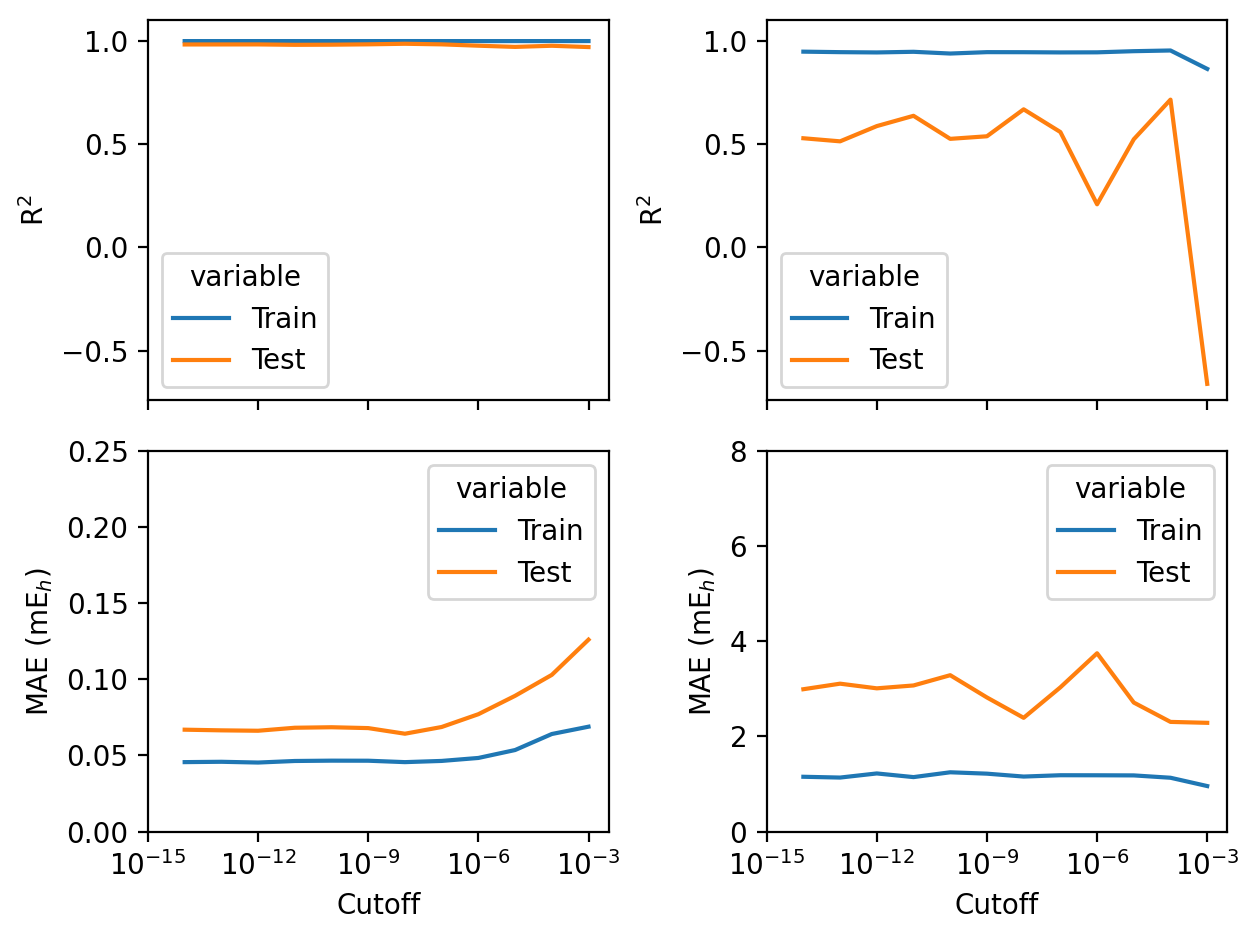

In [60]:
fig, ax = plt.subplots(2,2,sharex=True)
sns.lineplot(dfpair_r2.melt(id_vars='Cutoff',value_vars=['Train','Test']),x='Cutoff',y='value', hue='variable',ax=ax[0][0])
sns.lineplot(dfcorr_r2.melt(id_vars='Cutoff',value_vars=['Train','Test']),x='Cutoff',y='value', hue='variable',ax=ax[0][1],markers='x')
# ax[0][0].set_xlim(0,500)
# ax[0][1].set_xlim(0,500)
ax[0][0].set_xscale("log")
ax[0][1].set_xscale("log")
ax[0][0].set_ylim(-.74,1.1)
ax[0][1].set_ylim(-.74,1.1)
ax[0][0].set_xlim(10**-15,0)
# ax[0][1].set_xlim(-.74,1.1)
ax[0][0].set_ylabel("R$^{2}$")
ax[0][1].set_ylabel("R$^{2}$")
sns.lineplot(dfpair_mae.melt(id_vars='Cutoff',value_vars=['Train','Test']),x='Cutoff',y='value', hue='variable',ax=ax[1][0])
ax[1][0].set_ylim(0,0.25)
sns.lineplot(dfcorr_mae.melt(id_vars='Cutoff',value_vars=['Train','Test']),x='Cutoff',y='value', hue='variable',ax=ax[1][1])
ax[1][1].set_ylim(0,8)
ax[1][0].set_ylabel("MAE (mE$_{h}$)")
ax[1][1].set_ylabel("MAE (mE$_{h}$)")
plt.tight_layout()
plt.savefig('images/cutoff_curves.png',dpi=300,bbox_inches='tight')

In [63]:
dfcorr_r2.sort_values(by=['Train','Test'])

,Cutoff,Train,Test
11,1.000000e-03,0.863467,-0.659909
4,1.000000e-10,0.937796,0.525099
2,1.000000e-12,0.943082,0.586796
7,1.000000e-07,0.943168,0.558145
8,1.000000e-06,0.943608,0.208597
6,1.000000e-08,0.944234,0.667998
1,1.000000e-13,0.944479,0.513109
5,1.000000e-09,0.944515,0.537595
3,1.000000e-11,0.946227,0.636597
0,1.000000e-14,0.946877,0.528036
